# An Introduction to JAX

----

#### John Stachurski

#### Prepared for the CEF Workshop (June 2024)

----


This lecture provides a short introduction to [Google JAX](https://github.com/google/jax).

Let's quickly check our hardware:

In [27]:
!lscpu -e

CPU NODE SOCKET CORE L1d:L1i:L2:L3 ONLINE    MAXMHZ   MINMHZ      MHZ
  0    0      0    0 0:0:0:0          yes 5000.0000 800.0000 1665.457
  1    0      0    1 1:1:1:0          yes 5000.0000 800.0000  800.000
  2    0      0    2 2:2:2:0          yes 5000.0000 800.0000  800.000
  3    0      0    3 3:3:3:0          yes 5000.0000 800.0000 1096.023
  4    0      0    4 4:4:4:0          yes 5000.0000 800.0000  900.007
  5    0      0    5 5:5:5:0          yes 5000.0000 800.0000 4997.609
  6    0      0    6 6:6:6:0          yes 5000.0000 800.0000 4700.767
  7    0      0    7 7:7:7:0          yes 5000.0000 800.0000  800.000
  8    0      0    0 0:0:0:0          yes 5000.0000 800.0000  800.000
  9    0      0    1 1:1:1:0          yes 5000.0000 800.0000  800.000
 10    0      0    2 2:2:2:0          yes 5000.0000 800.0000  875.310
 11    0      0    3 3:3:3:0          yes 5000.0000 800.0000  954.845
 12    0      0    4 4:4:4:0          yes 5000.0000 800.0000 1105.913
 13    0      0    5

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [28]:
!nvidia-smi

Thu Jun 20 09:34:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   36C    P2             94W /  320W |    7745MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We'll use the following imports:

In [29]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Quick Speed Test -- JAX vs NumPy

Let's start with some speed comparisons between NumPy -- which is similar to Matlab -- and JAX.

(After that we'll look at learning how to use JAX more systematically.)


### Transformations

Let's evaluate the cosine function at 50 points.

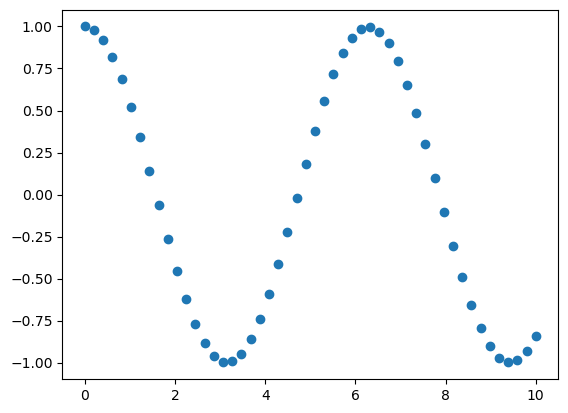

In [30]:
x = np.linspace(0, 10, 50)
y = np.cos(x)

fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

Now suppose we want to evaluate the cosine function at many points.

In [31]:
n = 50_000_000
x = np.linspace(0, 10, n)

#### With NumPy

In [32]:
%time y = np.cos(x)

CPU times: user 442 ms, sys: 18.1 ms, total: 460 ms
Wall time: 457 ms


In [33]:
del x, y

#### With JAX

In [34]:
x = jnp.linspace(0, 10, n)

Here's how we call the function:

In [35]:
y = jnp.cos(x)

Here's how we time it:

In [36]:
%time y = jnp.cos(x).block_until_ready()

CPU times: user 0 ns, sys: 1.25 ms, total: 1.25 ms
Wall time: 1.17 ms


In [37]:
del x, y

### Evaluating a more complicated function

Let's try this more complex function instead of `cos`

In [38]:
def f(x):
    y = np.cos(2 * x**2) + np.sqrt(np.abs(x)) + 2 * np.sin(x**4) - 0.1 * x**2
    return y

#### With NumPy

In [39]:
x = np.linspace(0, 10, n)

In [40]:
%time y = f(x)

CPU times: user 1.78 s, sys: 171 ms, total: 1.95 s
Wall time: 1.95 s


In [41]:
del x, y

#### With JAX

In [42]:
@jax.jit
def f(x):
    y = jnp.cos(2 * x**2) + jnp.sqrt(jnp.abs(x)) + 2 * jnp.sin(x**4) - x**2
    return y

In [43]:
x = jnp.linspace(0, 10, n)

Here's how we call the function.

In [44]:
y = f(x)

In [47]:
%time y = f(x).block_until_ready()

CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 1.77 ms


## JAX as a NumPy (or Matlab) replacement

### Similarities

In many ways, `jax.numpy` is similar to `numpy`

In [121]:
a = jnp.array((1.0, 3.2, -1.5))

In [128]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [129]:
jnp.sum(a)

Array(2.6999998, dtype=float32)

In [130]:
jnp.mean(a)

Array(0.9, dtype=float32)

In [131]:
jnp.dot(a, a)

Array(13.490001, dtype=float32)

In [132]:
a @ a  # Equivalent

Array(13.490001, dtype=float32)

However, the array object `a` is not a NumPy array:

In [133]:
type(a)

jaxlib.xla_extension.ArrayImpl

Notice also that scalar-valued maps on arrays return JAX arrays.

In [134]:
jnp.sum(a)

Array(2.6999998, dtype=float32)

Operations on higher dimensional arrays are also similar to NumPy:

In [135]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [136]:
jnp.linalg.inv(B)   # Inverse of identity is identity

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [137]:
result = jnp.linalg.eigh(B)  # Computes eigenvalues and eigenvectors
result.eigenvalues

Array([0.99999994, 0.99999994], dtype=float32)

In [138]:
result.eigenvectors

Array([[1., 0.],
       [0., 1.]], dtype=float32)

### Differences

Let's now look at the differences between JAX and NumPy

#### 32 bit floats

JAX uses 32 bit floats by default.

If necessary we can enforce 64 bit floats via

In [139]:
jax.config.update("jax_enable_x64", True)

Let's check this works:

In [140]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

#### Mutability


For example, with NumPy we can write

In [141]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [142]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails because arrays are immutable:

In [143]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [144]:
a[0] = 1   # uncommenting produces a TypeError

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Why???

## Random Numbers

Random numbers are also a bit different in JAX.  

(There are good reasons why, which we'll discuss later.)

### Controlling the state

In JAX, the state of the random number generator needs to be controlled explicitly.


First we produce a key, which seeds the random number generator.

In [45]:
key = jax.random.PRNGKey(1)

In [46]:
type(key)

jaxlib.xla_extension.ArrayImpl

Now we can use the key to generate some random numbers:

In [47]:
x = jax.random.normal(key, (3, 3))
x

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [48]:
jax.random.normal(key, (3, 3))

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

### Generating fresh draws

To produce a (quasi-) independent draw, we can use `split`

In [49]:
new_keys = jax.random.split(key, 5)   # Generate 5 new keys

In [50]:
len(new_keys)

5

In [51]:
for key in new_keys:
    print(jax.random.normal(key, (3, )))

[0.93781894 0.49680704 0.87546579]
[-0.98026784 -0.31413329  0.27581241]
[ 0.6358272  -1.04788243  0.41596996]
[ 1.68791384 -0.43438299 -1.11517741]
[ 1.40907666 -1.55242027 -0.62338347]


## JIT compilation

The JAX just-in-time (JIT) compiler generates efficient, parallelized machine
code optimized for either the CPU or the GPU/TPU, depending on whether one of
these accelerators is detected.


In [52]:
def f(x):
    a = jnp.sin(x) + jnp.cos(x**2)
    return jnp.sum(a)

Let's build an array to call the function on.

In [53]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [54]:
%time f(x).block_until_ready()

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 190 ms


Array(69088664.53380185, dtype=float64)

In [55]:
%time f(x).block_until_ready()

CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 12.2 ms


Array(69088664.53380185, dtype=float64)

What is JIT-compiled here?

### When does JAX recompile?

Let's run `f()` on new data:

In [56]:
y = jnp.ones(n + 1)

In [57]:
%time f(y).block_until_ready()

CPU times: user 65.6 ms, sys: 15.6 ms, total: 81.2 ms
Wall time: 148 ms


Array(69088665.91557515, dtype=float64)

Notice that the execution time increases again --- why??!

(This wouldn't happen with Julia/Numba, which recompile only if we change the
*types* of variables in a function call.)

In [58]:
%time f(y).block_until_ready()

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 11.9 ms


Array(69088665.91557515, dtype=float64)

And now runtime goes down again --- why?

Note that the previous compiled versions are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [59]:
%time f(x).block_until_ready()

CPU times: user 0 ns, sys: 1.23 ms, total: 1.23 ms
Wall time: 12.3 ms


Array(69088664.53380185, dtype=float64)

### Compiling user-built functions

As we saw above, we can also instruct JAX to compile an entire user-defined function.

For example, consider

In [60]:
def g(x):
    y = jnp.zeros_like(x)
    for i in range(10):
        y += x**i
    return y

In [61]:
n = 1_000_000
x = jnp.ones(n)

Let's time it.

In [62]:
%time g(x).block_until_ready()

CPU times: user 117 ms, sys: 8.81 ms, total: 126 ms
Wall time: 201 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [63]:
%time g(x).block_until_ready()

CPU times: user 4.67 ms, sys: 106 µs, total: 4.78 ms
Wall time: 3.18 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [64]:
g_jit = jax.jit(g)   # target for JIT compilation

Let's run once to compile it:

In [65]:
g_jit(x)

Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

And now let's time it.

In [66]:
%time g_jit(x).block_until_ready()

CPU times: user 320 µs, sys: 52 µs, total: 372 µs
Wall time: 344 µs


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

Why do we get a speed gain?

Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [67]:
@jax.jit
def g_jit_2(x):
    y = jnp.zeros_like(x)
    for i in range(10):
        y += x**i
    return y

In [68]:
%time g_jit_2(x).block_until_ready()

CPU times: user 26.3 ms, sys: 4.38 ms, total: 30.7 ms
Wall time: 26.2 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [69]:
%time g_jit_2(x).block_until_ready()

CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 1.55 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

## Functional Programming

From JAX's documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.
    
A pure function 

* will always return the same result if invoked with the same inputs (no dependence on external state) and
* have no side effects

### Examples: Python/NumPy/Numba style code is not generally pure

#### Example 1

Here's an example to show that NumPy functions are *not* pure:

In [70]:
np.random.randn(3)

array([-1.37754327, -0.98070141, -1.14174969])

In [71]:
np.random.randn(3)

array([ 0.49418621, -0.71920933, -0.90311109])

This function returns the different results when called on the same inputs!

The issue is that the function maintains state between function calls --- the state of the random number generator.

In [72]:
np.random.get_state()[2]

11

In [73]:
np.random.randn(3)

array([ 0.12719694, -0.65333293, -1.38785266])

In [74]:
np.random.get_state()[2]

19

#### Example 2

Is `f` pure?

In [75]:
a = 10
def f(x): 
    return a * x

In [76]:
f(1)

10

Now let's change the global:

In [77]:
a = 20

In [78]:
f(1)

20

#### Example 3

Is this function pure?  Why? / Why not?

In [79]:
def f(x):  
    x[0] = 42
    return None

x = np.ones(5)
x

array([1., 1., 1., 1., 1.])

In [80]:
f(x)

In [81]:
x

array([42.,  1.,  1.,  1.,  1.])

### Compiling impure functions

JAX will *not* usually throw errors when compiling impure functions 

However, execution becomes unpredictable!

Here's an illustration of this fact, using global variables:

In [82]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [83]:
x = jnp.ones(2)

In [84]:
f(x)

Array([2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected --- as long as the same compiled version is called.

In [85]:
a = 42

In [86]:
f(x)

Array([2., 2.], dtype=float64)

Notice that the change in the value of `a` takes effect in the code below:

In [87]:
x = jnp.ones(3)

In [88]:
f(x)

Array([43., 43., 43.], dtype=float64)

Why?

#### Moral

Moral of the story: write pure functions when using JAX!

## Writing vectorized code

Consider the function

$$
    f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $x$ and $y$ points.


### A slow version with loops

Here's a slow `for` loop version, which we run in a setting where `len(x) = len(y)` is very small.

In [89]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [90]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 2.71 s, sys: 559 ms, total: 3.27 s
Wall time: 2.51 s


Even for this small grid, the run time is slow.


OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply write

In [91]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn't understand the nested for loop.

In [92]:
z_bad.shape

(80,)

In [93]:
z_loops.shape

(80, 80)

### Vectorization attempt 1

To get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation that originated in MATLAB and was replicated in NumPy and then JAX:

In [94]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is fast.

In [95]:
z_mesh = f(x_mesh, y_mesh) 

Let's confirm that we got the right answer.

In [96]:
jnp.allclose(z_mesh, z_loops)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [97]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [98]:
%time z_mesh = f(x_mesh, y_mesh) 

CPU times: user 25.7 ms, sys: 0 ns, total: 25.7 ms
Wall time: 46.6 ms


In [99]:
%time z_mesh = f(x_mesh, y_mesh) 

CPU times: user 143 µs, sys: 0 ns, total: 143 µs
Wall time: 153 µs


But there is one problem here: the mesh grids use a lot of memory.

In [100]:
(x_mesh.nbytes + y_mesh.nbytes) / 1_000_000  # MB of memory

576.0

By comparison, the flat array `x` is just

In [101]:
x.nbytes / 1_000_000   # and y is just a pointer to x

0.048

In [102]:
x_mesh = None
y_mesh = None

### Vectorization attempt 2

We can achieve a similar effect through NumPy style broadcasting rules.

In [103]:
x_reshaped = jnp.reshape(x, (n, 1))   # Give x another dimension (column)
y_reshaped = jnp.reshape(y, (1, n))   # Give y another dimension (row)

When we evaluate $f$ on these reshaped arrays, we replicate the nested for loops in the original version.

In [104]:
%time z_reshaped = f(x_reshaped, y_reshaped)

CPU times: user 31.9 ms, sys: 3.26 ms, total: 35.1 ms
Wall time: 55.7 ms


In [105]:
%time z_reshaped = f(x_reshaped, y_reshaped)

CPU times: user 294 µs, sys: 51 µs, total: 345 µs
Wall time: 368 µs


Let's check that we got the same result

In [106]:
jnp.allclose(z_reshaped, z_mesh)

Array(True, dtype=bool)

The memory usage for the inputs is much more moderate.

In [107]:
(x_reshaped.nbytes + y_reshaped.nbytes) / 1_000_000

0.096

### Vectorization attempt 3


There's another approach to vectorization we can pursue, using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

In [108]:
f = jax.vmap(f, in_axes=(None, 0))   # vectorize in y
f = jax.vmap(f, in_axes=(0, None))   # and then vectorize in x

With this construction, we can now call the function $f$ on flat (low memory) arrays.

In [109]:
%time z_vmap = f(x, y)

CPU times: user 26.9 ms, sys: 455 µs, total: 27.3 ms
Wall time: 48.8 ms


In [110]:
%time z_vmap = f(x, y)

CPU times: user 777 µs, sys: 133 µs, total: 910 µs
Wall time: 943 µs


Let's check we produce the correct answer:

In [111]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

Let's finish by cleaning up.

In [112]:
del z_mesh
del z_vmap
del z_reshaped

### Exercises

Compute an approximation to $\pi$ by simulation:

1. draw $n$ observations of a bivariate uniform on the unit square
2. count the fraction that fall in the unit circle (radius 0.5) centered on (0.5, 0.5)
3. multiply the result by 4

Use JAX

In [113]:
for i in range(12):
    print("Solution below 🐠")

Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠


In [114]:
def approx_pi(n, key):
    u = jax.random.uniform(key, (2, n))
    distances = jnp.sqrt((u[0, :] - 0.5)**2 + (u[1, :] - 0.5)**2)
    fraction_in_circle = jnp.mean(distances < 0.5)
    return fraction_in_circle * 4  # dividing by radius**2

n = 1_000_000 # sample size for Monte Carlo simulation
key = jax.random.PRNGKey(1234)

In [115]:
%time approx_pi(n, key)

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 184 ms


Array(3.142108, dtype=float32)

In [116]:
%time approx_pi(n, key)

CPU times: user 3.46 ms, sys: 268 µs, total: 3.73 ms
Wall time: 1.97 ms


Array(3.142108, dtype=float32)

In [117]:
approx_pi_jitted = jax.jit(approx_pi, static_argnums=(0,))

In [118]:
%time approx_pi_jitted(n, key)

CPU times: user 57.2 ms, sys: 326 µs, total: 57.5 ms
Wall time: 99.6 ms


Array(3.142108, dtype=float32)

In [119]:
%time approx_pi_jitted(n, key)

CPU times: user 174 µs, sys: 0 ns, total: 174 µs
Wall time: 250 µs


Array(3.142108, dtype=float32)

**Exercise**

In a previous notebook we used Monte Carlo to price a European call option and
constructed a solution using Numba.

The code looked like this:

In [120]:
import numba
from numpy.random import randn
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@numba.jit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in numba.prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

Let's run it once to compile it:

In [121]:
compute_call_price_parallel()

148712.07481427447

And now let's time it:

In [122]:
%%time 
compute_call_price_parallel()

CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 916 ms


155885.53034715902

Try writing a version of this operation for JAX, using all the same
parameters.

If you are running your code on a GPU, you should be able to achieve
significantly faster execution.

In [123]:
for i in range(12):
    print("Solution below 🐠")

Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠
Solution below 🐠


**Solution**

Here is one solution:

In [124]:
@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))
        
    return β**n * expectation

Let's run it once to compile it:

In [125]:
compute_call_price_jax()

Array(180876.48840921, dtype=float64)

And now let's time it:

In [126]:
%%time 
compute_call_price_jax().block_until_ready()

CPU times: user 0 ns, sys: 2.84 ms, total: 2.84 ms
Wall time: 247 ms


Array(180876.48840921, dtype=float64)